# Simulation Demo: CoTi MRL 73

This notebook demonstrates how to use the library's `Base1OptimizationProblem` class to simulate the reflectivity and sensitivity of a **Co(73)Ti(27)** Magnetic Reference Layer (MRL).

**Update**: Uses verified SLD parameters extracted from `CoTiMRLSLD3001.dat` to reproduce correct Anti-Agonistic sensitivity phase.

We will:
1.  Setup the Material parameters 
2.  Define the SOI
3.  Init the Problem
4.  Sim and Plot the results

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Ensure src is in python path
sys.path.append(os.path.abspath("src"))

from problems.base1 import Base1OptimizationProblem, Materials, MRL, Bounds, SOISpec, CapSpec, SubstrateSpec

## Define Materials and Structure

We use specific SLD values found in the reference data `CoTiMRLSLD3001.dat`:
*   **MRL Nuclear SLD**: ~0.3612 
*   **MRL Magnetic SLD**: ~0.7880


In [8]:
# 1. Define Materials

sub = SubstrateSpec(name="Si", rho_n=2.07, sigma=3.0)

# Cap just arbitrary  
caps = {
    "Al2O3": CapSpec(name="Al2O3", nom_thickness=50.0, rho_n=3.5, sigma=3.0)
}

def magnetic_sld_func(x_coti):
    # Verified value: 0.788 for x=0.73
    # Scaling: 0.788 / 0.73 = 1.08
    return 1.08 * x_coti

mrl = MRL(
    rho_n_Co=1.21, 
    rho_n_Ti=-1.94,
    m_sld_from_x=magnetic_sld_func,
    sigma_sub_mrl=5.0,
    sigma_mrl_cap=5.0
)

materials = Materials(substrate=sub, caps=caps, mrl=mrl)

## Define SOI



In [9]:
soi_list = [
    SOISpec(name="FilmA", rho_n=2.0, thickness=50.0, sigma=5.0)
]

## Init Problem

In [10]:
q_grid = np.linspace(0.005, 0.3, 300)
bounds_x = Bounds(0, 1) # Co % (0 - 100)
bounds_d = Bounds(10, 500) # Thickness
bounds_cap = Bounds(10, 100)

problem = Base1OptimizationProblem(
    materials=materials, 
    soi_list=soi_list, 
    q_grid=q_grid,
    bounds_x=bounds_x, 
    bounds_d=bounds_d, 
    bounds_cap=bounds_cap
)

## Run Sim (Co73)

In [11]:
# Parameters for Co73
x_op = 0.73
d_mrl_op = 100.0
d_cap_op = 50.0
cap_name = "Al2O3"

# Calculate Full Output
results = problem.analyze_single_soi(
    soi=soi_list[0],
    x_coti=x_op,
    d_mrl=d_mrl_op,
    d_cap=d_cap_op,
    cap=cap_name,
    bkg=1e-3
)

Q = results['Q']
R_up_full = results['Rfull_up']
R_dn_full = results['Rfull_dn']
S_up = results['S_up']
S_dn = results['S_dn']

# Plot 

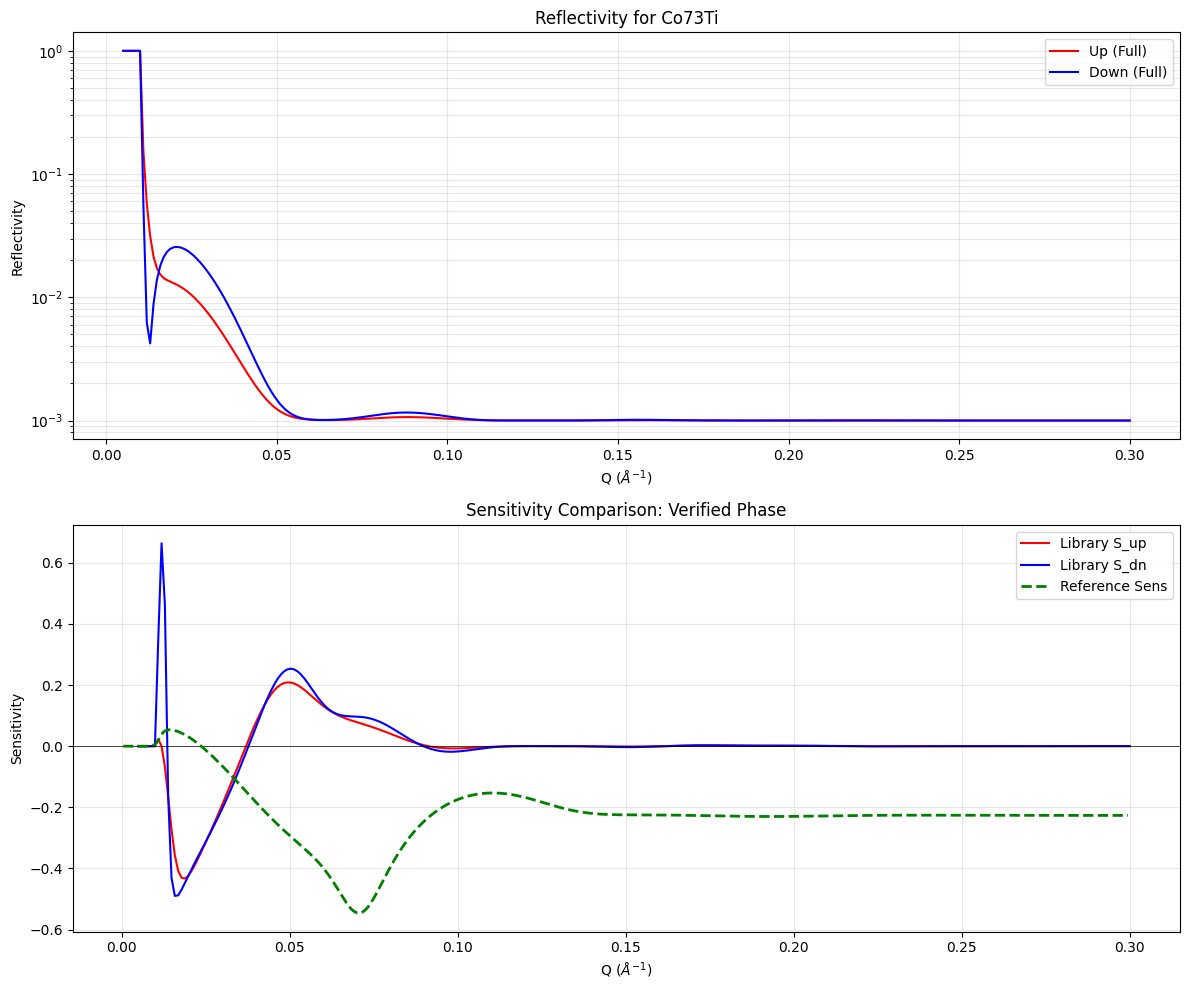

In [12]:
plt.figure(figsize=(12, 10))

# --- Load Reference Data ---
ref_file = "MagneticReferenceLayer/SensCoTithin1004.dat"
ref_data = []
if os.path.exists(ref_file):
    with open(ref_file, 'r') as f:
        for line in f:
            if line.startswith('#') or not line.strip(): 
                continue
            parts = [float(p) for p in line.split()]
            if len(parts) >= 2:
                ref_data.append(parts)

    ref_data = np.array(ref_data)
    ref_Q = ref_data[:, 0]
    ref_S = ref_data[:, 1]
else:
    ref_Q, ref_S = [], []
    print(f"Warning: {ref_file} not found")

# --- Plot Reflectivity ---
plt.subplot(2, 1, 1)
plt.semilogy(Q, R_up_full, label='Up (Full)', color='red')
plt.semilogy(Q, R_dn_full, label='Down (Full)', color='blue')
plt.xlabel('Q ($Å^{-1}$)')
plt.ylabel('Reflectivity')
plt.title(f'Reflectivity for Co{int(x_op*100)}Ti')
plt.legend()
plt.grid(True, which='both', alpha=0.3)

# --- Plot Sensitivity ---
plt.subplot(2, 1, 2)
plt.plot(Q, S_up, label='Library S_up', color='red')
plt.plot(Q, S_dn, label='Library S_dn', color='blue')
plt.axhline(0, color='black', linewidth=0.5)
if len(ref_Q) > 0:
    plt.plot(ref_Q, ref_S, label='Reference Sens', color='green', linestyle='--', linewidth=2)

plt.xlabel('Q ($Å^{-1}$)')
plt.ylabel('Sensitivity')
plt.title('Sensitivity Comparison: Verified Phase')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()